In [1]:
import sys
sys.path.append('/mnt/hdd/thuonglc/study/btl-aptos')

In [19]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from utils import load_checkpoint
from dataset import get_dataloaders
from config import Config
from model import APTOSModel
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

In [4]:
checkpoint_dir = "/mnt/hdd/thuonglc/study/btl-aptos/logs/checkpoints"
test_path = "/mnt/hdd/thuonglc/study/btl-aptos/data/val.csv"
image_size = 512

In [5]:
model = APTOSModel()
name = '59'
model, _, _ = load_checkpoint(checkpoint_dir, name, model)
model = model.cuda()

In [6]:
val_df = pd.read_csv(test_path)

In [7]:
trans = transforms.Compose([
                transforms.Resize([image_size, image_size]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
        ])

In [12]:
def get_grad_cam(img, aug_img, tgt_layer, tgt_class):
    tgt_layer = [tgt_layer]
    cam = GradCAM(model=model, target_layers=tgt_layer, use_cuda=True)
    # if tgt_class is None:
    #     targets = [ClassifierOutputTarget(l) for l in [0, 1, 2, 3, 4]]
    # else:
    targets = [ClassifierOutputTarget(tgt_class)]
    grayscale_cam = cam(input_tensor=aug_img, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    return visualization

def get_aug_img(index, val_df, trans, image_size=512):
    img = Image.open(val_df.path[index]).convert('RGB').resize((image_size, image_size))
    aug_img = trans(img).unsqueeze(0)
    img = np.asarray(img) / 255.0
    return img, aug_img

In [101]:
# for many classes on one image
#
# targets = [ClassifierOutputTarget(l) for l in [0, 1, 2, 3, 4]]
# grayscale_cam = cam(input_tensor=aug_img, targets=targets)

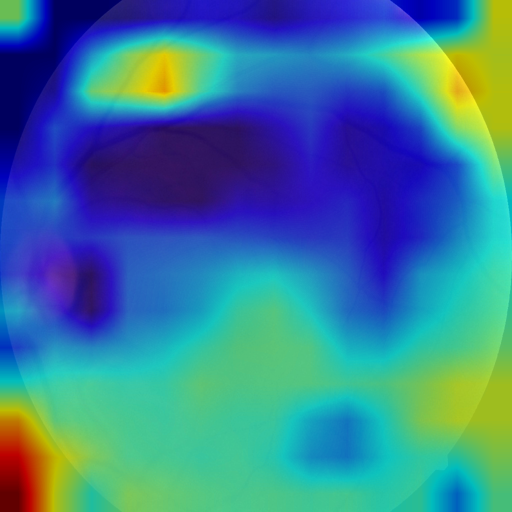

In [20]:
index = 30
tgt_layer = model.backbone.conv2d_7b.bn
tgt_class = val_df.diagnosis[index]
img, aug_img = get_aug_img(index, val_df, trans,  image_size)
grad_cam_vis = get_grad_cam(img, aug_img, tgt_layer, tgt_class)
Image.fromarray(grad_cam_vis, 'RGB')